In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
torch.set_default_dtype(torch.double)

In [3]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"  # CPU is faster in our use case
print(f"Using {device} device")

Using cpu device


In [4]:
def train(dataloader, model, loss_fn, optimizer, print_frequency=0):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if print_frequency > 0 and batch % print_frequency == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [5]:
def test(dataloader, model, loss_fn, print_loss=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    if print_loss:
        print(f"Test Error: Avg loss: {test_loss:>8f} \n")
    return test_loss

In [6]:
def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy().copy()

class LogActivation(nn.Module):
    def forward(self, x):
        return torch.log(x)
        return torch.log(torch.maximum(x, torch.tensor(1e-10)))
    
class ExpActivation(nn.Module):
    def forward(self, x):
        return torch.exp(x)

# Define model
class PolynomialNN(nn.Module):
    def __init__(self, n_monomials=1, exponent_bias=True):
        super(PolynomialNN, self).__init__()
        self.stack = nn.Sequential(
            LogActivation(),
            nn.Linear(1, n_monomials, bias=exponent_bias),
            ExpActivation(),
            nn.Linear(n_monomials, 1)
        )
        self.exponent_bias = exponent_bias
        
    def forward(self, x):
        x = self.stack(x)
        return x
    
    @property
    def exponent_layer(self):
        return self.stack[1]
    
    @property
    def coefficient_layer(self):
        return self.stack[3]
    
    def get_exponents(self):
        return tensor_to_numpy(self.stack[1].weight)
    
    def get_coefficients(self):
        coefficients = tensor_to_numpy(self.coefficient_layer.weight)
        if self.exponent_bias:
            coefficients *= np.exp(tensor_to_numpy(self.exponent_layer.bias))
        return coefficients
    
    def get_bias(self):
        return tensor_to_numpy(self.coefficient_layer.bias)
    
    def exponents_abs_(self):
        self.exponent_layer.weight.abs_()

In [7]:
# Define Data
class DatasetFromFunction(Dataset):
    def __init__(self, sample_fn, target_fn, size, noise_fn = None, positive_only=False):
        self.x = sample_fn(size)[:, None]
        if positive_only:
            self.x = torch.abs(self.x)
        self.y = target_fn(self.x)
        if noise_fn:
            self.y += noise_fn(size)
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [8]:
def get_polynomial_fn(coefficients):
    def polynomial(x):
        val = 0
        for c in coefficients:
            val = val * x + c
        return val
    
    return polynomial

In [9]:
def truncated_normal(n, min_val, rng=None, mean=0., std=1.):
    normal_sample = lambda: torch.normal(mean, std, (n,), generator=rng)
    x = normal_sample()
    while (x < min_val).any():
        x_new = normal_sample()
        x[x < min_val] = x_new[x < min_val]
    return x

# Convergence Experiments

Generate the training and test set

Text(0.5, 1.0, 'Training Set')

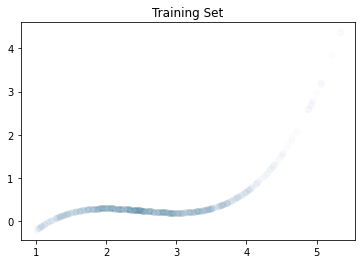

In [10]:
rng = torch.Generator(device="cpu")
rng.manual_seed(0)
# sample_fn = lambda n: torch.normal(0, 1, (n,), generator=rng)
sample_fn = lambda n: truncated_normal(n, 1, rng, mean=2.5)
coefficients = np.array([2, -15, 36, -25]) / 10
target_fn = get_polynomial_fn(coefficients)
# target_fn = lambda x: x**2 - 4*x + 2
training_data = DatasetFromFunction(sample_fn, target_fn, 1000)
val_data = DatasetFromFunction(sample_fn, target_fn, 100)
test_data = DatasetFromFunction(sample_fn, target_fn, 100)

train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)
val_dataloader = DataLoader(training_data, batch_size=128)
test_dataloader = DataLoader(test_data, batch_size=128)

plt.scatter(training_data[:][0], training_data[:][1], alpha=0.01)
plt.title("Training Set")

Initialize the model

In [11]:
torch.manual_seed(68225)
n_coefficients = len(coefficients)
model = PolynomialNN(n_coefficients-1).to(device)
with torch.no_grad():
    model.exponents_abs_()
print(model)

total_epochs = 0
exponent_path = [model.get_exponents()]
coefficient_path = [model.get_coefficients()]
bias_path = [model.get_bias()]
loss_path = [test(test_dataloader, model, loss_fn, False)]

PolynomialNN(
  (stack): Sequential(
    (0): LogActivation()
    (1): Linear(in_features=1, out_features=3, bias=True)
    (2): ExpActivation()
    (3): Linear(in_features=3, out_features=1, bias=True)
  )
)


Train the model

In [12]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.8, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, verbose=True)

In [13]:
epochs = 1000
for t in tqdm(range(epochs)):
    train(train_dataloader, model, loss_fn, optimizer)
    scheduler.step(test(val_dataloader, model, loss_fn, False))
    exponent_path.append(model.get_exponents())
    coefficient_path.append(model.get_coefficients())
    bias_path.append(model.get_bias())
    loss_path.append(test(test_dataloader, model, loss_fn, False))
test(test_dataloader, model, loss_fn)
print("Done!")

100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.86it/s]

Test Error: Avg loss: 0.041196 

Done!


Text(0.5, 1.0, 'Test Loss')

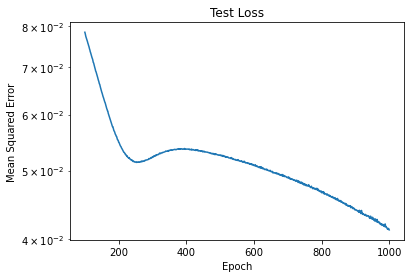

In [14]:
loss_start_epoch = 100
plt.plot(range(loss_start_epoch, epochs+1), loss_path[loss_start_epoch:])
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.yscale("log")
plt.title("Test Loss")

In [15]:
# Condense paths into arrays
exponent_path = np.stack(exponent_path)[:,:,0]
coefficient_path = np.stack(coefficient_path)[:,0,:]
bias_path = np.stack(bias_path)

# Sort from lowest to largest exponent
ind = np.argsort(exponent_path[-1])
exponent_path = exponent_path[:, ind]
coefficient_path = coefficient_path[:, ind]
coefficient_path = np.hstack([bias_path, coefficient_path])  # bias matches the oi-th degree coefficient

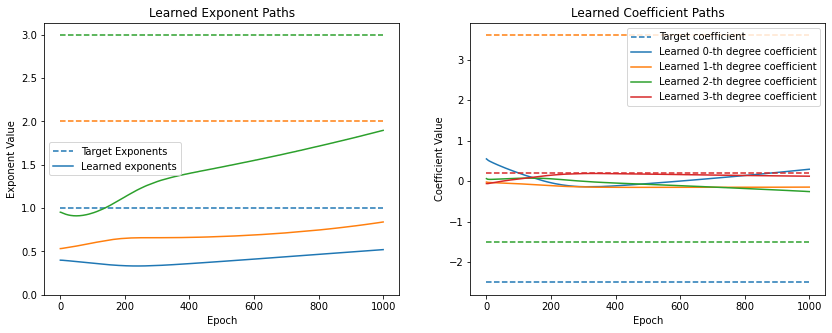

In [16]:
# Prepare for plotting
fig, ax = plt.subplots(1, 2, figsize = (14, 5))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Plot the exponents path
for i, path in enumerate(exponent_path.T):
    label = "Target Exponents" if i == 0 else None
    ax[0].plot(np.full(epochs+1, i+1), label=label, c=colors[i], ls="--")
    label = "Learned exponents" if i == 0 else None
    ax[0].plot(path, label=label, c=colors[i])

plot_bottom = ax[0].get_ylim()[0]
if plot_bottom > 0:
    ax[0].set_ylim(0)
        
ax[0].set_title("Learned Exponent Paths")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Exponent Value")
ax[0].legend()

# Plot the coefficient paths
for degree, (coefficient, path) in enumerate(zip(coefficients[::-1], coefficient_path.T)):
    label = "Target coefficient" if degree == 0 else None
    ax[1].plot(np.full(epochs+1, coefficient), label=label, c=colors[degree], ls="--")
    label = f"Learned {degree}-th degree coefficient"
    ax[1].plot(path, label=label, c=colors[degree])
        
ax[1].set_title("Learned Coefficient Paths")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Coefficient Value")
ax[1].legend()

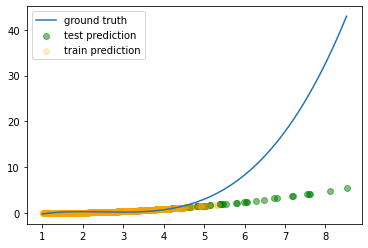

In [17]:
train_x = training_data[:][0]
test_x = test_data[:][0] * 2 - 1
# test_x = torch.normal(0, 3, (100,), generator=rng)[:, None].abs()
x = torch.cat((train_x, test_x))
x = torch.from_numpy(np.linspace(x.min(), x.max(), 200))

model.eval()
model.to('cpu')
plt.plot(x, target_fn(x), label="ground truth")
plt.scatter(test_x, model(test_x).detach(), c="green", alpha=0.5, label="test prediction")
plt.scatter(train_x, model(train_x).detach(), c="orange", alpha=0.2, label="train prediction")
model.to(device)
plt.legend()

In [18]:
model.get_exponents()

array([[1.89550374],
       [0.83956957],
       [0.52076288]])

In [19]:
model.get_coefficients(), model.get_bias()

(array([[ 0.12308437, -0.25704635, -0.14624791]]), array([0.29463245]))